# Project Abysima: Generating a Language with Machine Learning

The following notebook will experiment with generating a language using neural networks and generative deep learning.
This is, by no means, a production-ready system, nor is it a complete network; rather, the purpose of this experiment
is to see what is possible with creating a language.

For more information on the process and supporting research, please refer to the Linguistics Paper document found in the
`01 - Areas of Responsibility` directory.

The following source code and datasets are licensed under the Mozilla Public License v2.0. Please refer to the LICENSE
file that came with this repository for more information on what your rights are with usage and modification of this
software. If a LICENSE file is not provided, you can obtain a copy at https://www.mozilla.org/en-US/MPL/2.0/.

## Part 1: Initial Setup

We'll need to write some utilities and codes that will allow us to generate, predict, and validate words. This
section will allow us to do just that.

In [1]:
# Import Keras, the primary library for generating neural networks more efficiently.
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Import our random string generator.
from random_strings import new_word

# Import the CSV reader to read the datasets imported from Kaggle.
import pandas as pd

# Import the numpy library to create more complex arrays that Keras can use.
import numpy as np

# Import pyplot to plot data as necessary.
from matplotlib import pyplot as plt

In [2]:
# Grab the English and Japanese words from the Kaggle datasets. More information on where the data originated from
# can be found in kaggle/INFO.txt.

valid_words = pd.read_csv("outside_sources/unigram_freq.csv")
valid_words = list(valid_words.word) # We're only interested in the word column.
print(len(valid_words))

with open("outside_sources/jp-romaji.txt") as jp_data:
    valid_words += [w.strip() for w in jp_data.readlines()]


print(len(valid_words))

333333
333948


In [3]:
# Create a bunch of nonsencial words that are not valid.
invalid_syls = ["VVCCC", "CC", "VVVCCC", "CCC"]
invalid = [new_word(min=4, syllable=invalid_syls[i % len(invalid_syls)]) for i in range(len(valid_words))]
print(invalid[:10])

['eucvvaytjty', 'mbmsvf', 'aoulqneion', 'xrjpcmpvc', 'auwnryaqlx', 'jvjpjkl', 'aiolspaeykc', 'lwndzqt', 'yoqsveanwgu', 'djwz']


In [4]:
# Grab the contents of the test dictionary, which contains completely randomly-generated words from the random
# string generator that came with this project. These test words will be filtered by our neural network based
# on its rules for validation.

with open("test_dict.txt", "r") as dict_file:
    test_dict = [word.strip() for word in dict_file.readlines()]

print(test_dict[:10])

['xewetov', 'rskyesphbdj', 'wudnanvo', 'does', 'doowkguy', 'qtasvymmeq', 'hihebuxa', 'kftealnlhnp', 'gevhenly', 'deacgiecj']


In [5]:
# Assemble the dataset with the valid and invalid words. Words that are valid will be marked as 1 for its output,
# and words that are not valid are marked as 0 for its output.
from string import ascii_lowercase
def map_word(word: str) -> list:
    return [ascii_lowercase.index(c) + 1 for c in word]

# Unmaps a list of integers to a real word.
def unmap_word(word: list) -> str:
    result = ""
    for num in word:
        if num == -1:
            continue
        result = result + ascii_lowercase[num-1]
    return result

# Fill any shorter words with the maximum length of the words. For words shorter than the word with the most
# characters, a -1 will be subsistuted afterwards to keep the length of features consistent.
def fill_word_features(word: list, fill_length: int) -> list:
    if len(word) >= fill_length:
        return word
    diff = fill_length - len(word)
    return word + [-1 for i in range(diff)]

# Get the length of the longest word in the valid words dataset.
max_len = max([len(str(w)) for w in valid_words])

# Encode the data set into a format that the neural network will be able to understand.
encoded_correct = [map_word(str(word)) for word in valid_words]
encoded_correct = [fill_word_features(w, max_len) for w in encoded_correct]

encoded_invalid = [map_word(str(word)) for word in invalid]
encoded_invalid = [fill_word_features(w, max_len) for w in encoded_invalid]

# Map the values with their corresponding outputs.
mapped_correct = [word + [1] for word in encoded_correct]
mapped_invalid = [word + [0] for word in encoded_invalid]

dataset = mapped_correct + mapped_invalid

# Shuffle the dataset around.
from random import shuffle
for _ in range(20):
    shuffle(dataset)

# Cast the dataset to a numpy array, and split the features from the expected output.
dataset = np.array(dataset)
X = dataset[:, :-1]
Y = dataset[:,  -1]
print(X[:5])
print(Y[:5])

[[ 3 15 18 14 18 15 23 19 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [12  9  2 24  5 24 20 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [14  5 23 19  2  1 14 11 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 2  9  2 12  9 15  7 18  1 16  8  9  5 19 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 25  5  7 12 12 15  9 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[1 1 1 1 0]


## Part 2: Splitting Models for Validation and Testing

In order to prevent the neural network we will generate from overcorrecting itself or memorizing the data we give
it, we will create three different sets of the dataset: a training set, a validation set, and a testing set. The
training set will be used to train the model, and the model will use the validation set occasionally to validate
that it isn't overfitting. We will then use the testing set to test out the model and see what comes out of it.

To accomplish this, we will use a 60% training/20% validation/20% testing split for the datasets.

In [6]:
# Split the data in training and testing data. When we fit the model, we can specify a validation set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## Part 3: Creating The Predictive Model

Now that we have a dataset, we will create the neural network model with Keras and fit it using the training data.
This will also use a small portion of that data for validation purposes.

In [7]:
# Start by creating the model.
model = keras.Sequential()
model.add(Dense(max_len, input_dim=max_len, activation='relu'))
model.add(Dense(max_len, activation='relu'))
model.add(Dense(1, activation='softmax'))

# Create an early stopping mechanism to stop early if accuracy isn't improving after a certain point. This prevents
# unnecessary computations.
stop_early = EarlyStopping(monitor='accuracy', patience=5)

# Compile the model.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
# Fit the model to our dataset. In this instance, the model will run a batch gradient descent learning algorithm
# for 100 epochs with a batch size of 16. Additionally, it will set aside 20% of the data for validation.
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_split=0.2, callbacks=[stop_early])

Epoch 1/100
26716/26716 [==============================] - 32s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5004 - val_loss: 0.0000e+00 - val_accuracy: 0.5007
Epoch 2/100
26716/26716 [==============================] - 32s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5004 - val_loss: 0.0000e+00 - val_accuracy: 0.5007
Epoch 3/100
26716/26716 [==============================] - 32s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5004 - val_loss: 0.0000e+00 - val_accuracy: 0.5007
Epoch 4/100
26716/26716 [==============================] - 32s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5004 - val_loss: 0.0000e+00 - val_accuracy: 0.5007
Epoch 5/100
26716/26716 [==============================] - 31s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5004 - val_loss: 0.0000e+00 - val_accuracy: 0.5007
Epoch 6/100
26716/26716 [==============================] - 32s 1ms/step - loss: 0.0000e+00 - accuracy: 0.5004 - val_loss: 0.0000e+00 - val_accuracy: 0.5007


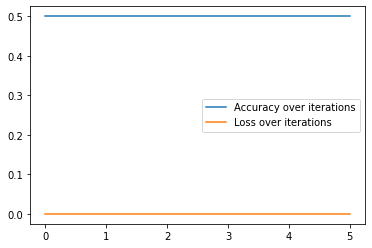

In [9]:
# Plot the accuracy and loss changes for comparison. If we see an overlap, there may be overfitting involved.
plt.plot(history.history['accuracy'], label='Accuracy over iterations')
plt.plot(history.history['loss'], label='Loss over iterations')
plt.legend()

## Part 4: Testing with the Testing Set

Now that the model is trained, we will use the testing set to test the results of the model's fitting process.

In [10]:
# Predict the testing data.
test_predictions = model.predict(X_test)

# Go through each of the predictions and store the number of predictions it got correct, and capture any failed
# predictions for inspection.
number_correct = 0
errors = []
for idx, prediction in enumerate(test_predictions):
    actual = y_test[idx]
    if prediction == actual:
        number_correct += 1
    else:
        errors.append((idx, prediction, actual))

# Calculate the accuracy percentage.
accuracy_percentage = (number_correct / len(y_test)) * 100
print(f"Percent correct: {accuracy_percentage:02f}%")

# Print all of the incorrect predictions.
print("===Incorrect Predictions===")
for idx, pred, act in errors:
    word = unmap_word(X_test[idx])
    pred_str = "valid" if pred else "invalid"
    act_str = "valid" if act else "invalid"
    print(f"Prediction was {pred_str},\t where actual was {act_str}\t\tWord: {word}")

Percent correct: 49.809103%
===Incorrect Predictions===
Prediction was valid,	 where actual was invalid		Word: iuowwqy
Prediction was valid,	 where actual was invalid		Word: eaaqftuiet
Prediction was valid,	 where actual was invalid		Word: yodcwa
Prediction was valid,	 where actual was invalid		Word: ourdgia
Prediction was valid,	 where actual was invalid		Word: eyekvzieo
Prediction was valid,	 where actual was invalid		Word: aitzs
Prediction was valid,	 where actual was invalid		Word: oozztai
Prediction was valid,	 where actual was invalid		Word: whlpsrnmjhw
Prediction was valid,	 where actual was invalid		Word: xxknrnw
Prediction was valid,	 where actual was invalid		Word: ealfkaaqq
Prediction was valid,	 where actual was invalid		Word: ghnqpqp
Prediction was valid,	 where actual was invalid		Word: bhpqhthqzt
Prediction was valid,	 where actual was invalid		Word: oiufhtoyi
Prediction was valid,	 where actual was invalid		Word: glfgwnvsh
Prediction was valid,	 where actual was invalid

## Part 5: Filtering Out "Invalid" Words in the Test Dictionary

Now that we have model that seems to be reasonably accurate, we can use our test dictionary to filter out words
that the network considers invalid.

In [11]:
# Encode the test_dict the same way we encoded the dataset.
encoded_test = [map_word(w) for w in test_dict]
encoded_test = [fill_word_features(w, max_len) for w in encoded_test]

# Make predictions of the test_dict and collect all of the words it considered valid.
dict_predictions = model.predict(encoded_test)
valid_dictionary = []
for idx, prediction in enumerate(dict_predictions):
    if prediction == 0:
        continue
    word = unmap_word(encoded_test[idx])
    valid_dictionary.append(word)

# Print some of the valid words, as well as how big the list actually is.
trim_count = len(test_dict) - len(valid_dictionary)
print(f"Trimmed {trim_count} invalid words from the test dictionary (now size {len(test_dict)}).")
print(valid_dictionary[:10])

Trimmed 0 invalid words from the test dictionary (now size 500).
['xewetov', 'rskyesphbdj', 'wudnanvo', 'does', 'doowkguy', 'qtasvymmeq', 'hihebuxa', 'kftealnlhnp', 'gevhenly', 'deacgiecj']
